In [31]:
import pickle
import pandas as pd
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import relu, elu, swish

from imblearn.over_sampling import SMOTE

In this new notebook, after executing several models in the previous pre-processing.ipynb, we load the best models obtained and apply GridSearchCV for hyperparameter tuning. 

Since the results from GridSearchCV are not satisfactory, we then implement an ANN. Additionally, we experiment with different train-test splits to further improve the models' performance metrics.

In [32]:
'''Load the Logistic Regression model'''
with open('models/logistic_regression_model.pkl', 'rb') as file:
    log_reg = pickle.load(file)

'''Load the Decision Tree model'''
with open('models/decision_tree_model.pkl', 'rb') as file:
    tree_clf = pickle.load(file)

'''Load the Random Forest model'''
with open('models/random_forest_model.pkl', 'rb') as file:
    rf_clf = pickle.load(file)

'''Load the Support Vector Machine model'''
with open('models/svm_model.pkl', 'rb') as file:
    svm_clf = pickle.load(file)


In [34]:
df3 = pd.read_csv('models/models.csv')
df3.head(2)

,complaint_description,complaint_type,status,diff_days,diff_days_int,city,county,incident_zip,latitude,longitude,location,owning_department,source,created_date,close_date,year,month
0,Arr Missed Recycling,SWSRECYC,Closed,6.493056,7,Austin,TRAVIS,78753.0,30.405236,-97.651363,(30.40523617 -97.65136271),Austin Resource Recovery,Phone,2014-02-05 14:14:47,2014-02-12 02:04:47,2014,2
1,Injured / Sick Animal,COAACINJ,Closed,0.904954,1,Austin,TRAVIS,78660.0,30.417750,-97.630697,(30.41774955 -97.63069739),Animal Services Office,Phone,2016-10-20 13:35:05,2016-10-21 11:18:13,2016,10


In [35]:
df3.shape

(309082, 17)

## The models
We brings the same columns

In [45]:
df4 = df3[['status','diff_days_int', 'complaint_type', 'source', 'owning_department']]

In [46]:
df4['status'] = df4['status'].str.strip()
df4['source'] = df4['source'].str.strip()

'''Convert 'status' and 'source' to binary values'''
status_mapping = {'Closed': 1, 'Open': 0}
source_mapping = {'Phone': 1, 'Non-phone': 0}

df4['status'] = df4['status'].map(status_mapping)
df4['source'] = df4['source'].map(source_mapping)


/var/folders/_m/x_6kdcg111940vvx5zz0_c7r0000gn/T/ipykernel_1240/2376075734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['status'] = df4['status'].str.strip()
/var/folders/_m/x_6kdcg111940vvx5zz0_c7r0000gn/T/ipykernel_1240/2376075734.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['source'] = df4['source'].str.strip()
/var/folders/_m/x_6kdcg111940vvx5zz0_c7r0000gn/T/ipykernel_1240/2376075734.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [57]:
'''Prepare X and y'''
y = df4['status']
X = df4[['diff_days_int', 'source']]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)

'''Print the sizes of the training and test sets'''
print("Training set size:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

print("\nTesting set size:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Training set size:
X_train: (247265, 2)
y_train: (247265,)

Testing set size:
X_test: (61817, 2)
y_test: (61817,)


## Implementation of Resampling Techniques
Let's start with implementing oversampling using SMOTE and then retrain the models:

In [59]:

'''Apply SMOTE to the training set'''
smote = SMOTE(random_state=12)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

'''Load the scaler object from the file'''
with open('models/scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

In [60]:
columns = X_train.columns
X_train_resampled = pd.DataFrame(data=X_train_resampled, columns=columns)
y_train_resampled = pd.DataFrame(data=y_train_resampled, columns=['status'])


In [61]:
'''Checking the new distribution of our data'''
print("length of oversampled data is ",len(X_train_resampled))
print("Number of Open request in oversampled data",len(y_train_resampled[y_train_resampled['status']==0]))
print("Number of Closed request",len(y_train_resampled[y_train_resampled['status']==1]))
print("Proportion of Open request data in oversampled data is ",len(y_train_resampled[y_train_resampled['status']==0])/len(X_train_resampled))
print("Proportion of Closed request data in oversampled data is ",len(y_train_resampled[y_train_resampled['status']==1])/len(X_train_resampled))

length of oversampled data is  464000
Number of Open request in oversampled data 232000
Number of Closed request 232000
Proportion of Open request data in oversampled data is  0.5
Proportion of Closed request data in oversampled data is  0.5


In [62]:
'''
Transform the training and testing data using the loaded scaler
Standardize features (important for some algorithms like SVM)
'''
X_train_scaled = scaler.transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [12]:
'''predictions with the loaded models'''
y_pred_log_reg = log_reg.predict(X_test_scaled)
y_pred_tree = tree_clf.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)
y_pred_svm = svm_clf.predict(X_test_scaled)

In [13]:
'''Models Performance'''
print("Logistic Regression:")
print(classification_report(y_test, y_pred_log_reg))
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg)}\n")

print("Decision Tree:")
print(classification_report(y_test, y_pred_tree))
print(f"Accuracy: {accuracy_score(y_test, y_pred_tree)}\n")

print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}\n")

print("Support Vector Machine:")
print(classification_report(y_test, y_pred_svm))
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}\n")

Logistic Regression:
              precision    recall  f1-score   support

           0       0.09      0.82      0.17      6760
           1       0.98      0.48      0.64    102328

    accuracy                           0.50    109088
   macro avg       0.53      0.65      0.40    109088
weighted avg       0.92      0.50      0.61    109088

Accuracy: 0.4973140950425345

Decision Tree:
              precision    recall  f1-score   support

           0       0.41      0.49      0.45      6760
           1       0.97      0.95      0.96    102328

    accuracy                           0.93    109088
   macro avg       0.69      0.72      0.70    109088
weighted avg       0.93      0.93      0.93    109088

Accuracy: 0.9253630096802581

Random Forest:
              precision    recall  f1-score   support

           0       0.41      0.49      0.45      6760
           1       0.97      0.95      0.96    102328

    accuracy                           0.93    109088
   macro avg     

Applying GridSearchCV for hyperparameter tuning of the Random Forest model

In [15]:
'''Converting to series y_train_resampled and y_test are DataFrames'''
y_train_resampled = y_train_resampled.squeeze()
y_test = y_test.squeeze()


In [17]:
from sklearn.model_selection import GridSearchCV

'''Define the parameter grid'''
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 10],
    'max_features': ['auto', 'sqrt', 'log2']
}

'''Initialize GridSearchCV'''
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

'''Fit the model'''
grid_search.fit(X_train_resampled, y_train_resampled)

'''Get the best parameters and best score'''
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

'''Evaluate the best model on the test set'''
best_rf_clf = grid_search.best_estimator_
y_pred_rf_best = best_rf_clf.predict(X_test)


Fitting 3 folds for each of 960 candidates, totalling 2880 fits
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, 

/Users/jorgeccorrov/anaconda3/envs/m-bts/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
960 fits failed out of a total of 2880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
327 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jorgeccorrov/anaconda3/envs/m-bts/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jorgeccorrov/anaconda3/envs/m-bts/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/jorgeccorrov/anaconda3/envs/m-bts/lib/python3.10/site-packages/sklearn/base.py", line 

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Score: 0.7212211496881343


In [18]:
print("Random Forest (Best Model):")
print(classification_report(y_test, y_pred_rf_best))
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_best)}")

Random Forest (Best Model):
              precision    recall  f1-score   support

           0       0.41      0.49      0.45      4506
           1       0.97      0.95      0.96     68220

    accuracy                           0.93     72726
   macro avg       0.69      0.72      0.71     72726
weighted avg       0.93      0.93      0.93     72726

Accuracy: 0.9254461953084179


**Symmary**

- Best Parameters: The GridSearchCV found the best parameters for the Random Forest model. These parameters optimized the model's performance based on the training data.
- Best Score on Training Data: The best score on the training data using cross-validation.
- Test Set Performance: The evaluated performance metrics on the test set including precision, recall, f1-score, and accuracy.

The high accuracy and recall for class 1 (Closed requests) indicate that the model performs well in identifying closed requests. However, the performance for class 0 (Open requests) could be further improved.



## Applying some ANN for the Random Forest model

In [63]:
'''Set the random seed for reproducibility'''
SEED = 5
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [64]:
'''Define the model for classification'''
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.35))
model.add(Flatten())  # Flatten the 3D tensor to 2D tensor for Dense layers
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.003)))
model.add(Dropout(0.35))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.003)))
model.add(Dropout(0.35))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.003)))
model.add(Dropout(0.35))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.003)))
model.add(Dropout(0.35))
model.add(Dense(1, activation='sigmoid'))  # Output layer suitable for binary classification

'''Compile the model for classification'''
optimizer = Adam(learning_rate=0.003, weight_decay = 0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
'''Early stopping to prevent overfitting'''
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

'''Fit the model'''
history = model.fit(X_train_scaled, y_train_resampled, epochs=150, batch_size=64,
                    validation_data=(X_test_scaled, y_test), verbose=3, callbacks=[early_stopping])

'''Evaluate the model using classification metrics'''
loss_train, accuracy_train = model.evaluate(X_train_scaled, y_train_resampled)
loss_test, accuracy_test = model.evaluate(X_test_scaled, y_test)
print('Loss on training set:', loss_train)
print('Accuracy on training set:', accuracy_train)
print('Loss on test set:', loss_test)
print('Accuracy on test set:', accuracy_test)

'''Predict on the test set'''
y_pred_ann_prob = model.predict(X_test_scaled)
y_pred_ann = (y_pred_ann_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

'''Evaluate the model'''
print("ANN Model:")
print(classification_report(y_test, y_pred_ann))
print(f"Accuracy: {accuracy_score(y_test, y_pred_ann)}")

Epoch 1/150
Epoch 2/150
Epoch 3/150
Epoch 4/150
Epoch 5/150
Epoch 6/150
Epoch 7/150
Epoch 8/150
Epoch 9/150
Epoch 10/150
Epoch 11/150
1932/1932 [==============================] - 1s 359us/step - loss: 0.5025 - accuracy: 0.9263
Loss on training set: 0.5454655885696411
Accuracy on training set: 0.7223383784294128
Loss on test set: 0.5024595260620117
Accuracy on test set: 0.9262500405311584
1932/1932 [==============================] - 1s 316us/step
ANN Model:
              precision    recall  f1-score   support

           0       0.42      0.49      0.45      3816
           1       0.97      0.95      0.96     58001

    accuracy                           0.93     61817
   macro avg       0.69      0.72      0.71     61817
weighted avg       0.93      0.93      0.93     61817

Accuracy: 0.9262500606629245


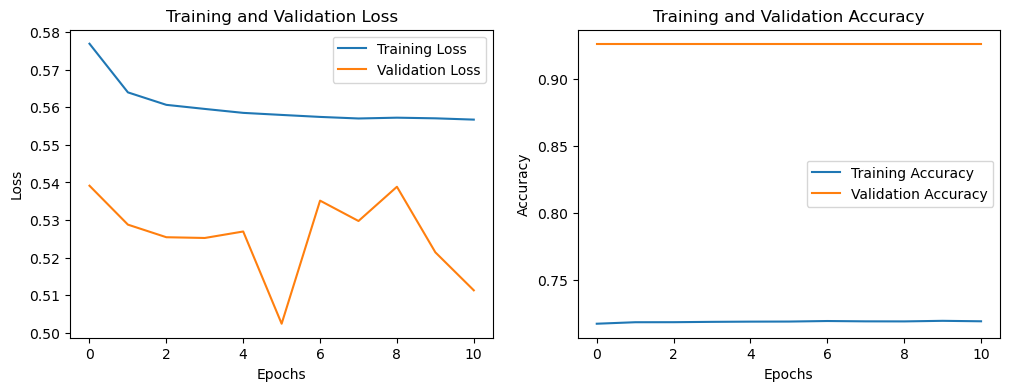

In [65]:

'''Plot the loss function'''
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

'''Plot the accuracy'''
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


### Performance Metrics

**Training and Validation Loss:**

*Training Loss*: The plot shows a steady decrease in training loss over the epochs, indicating that the model is learning from the training data.

*Validation Loss*: The validation loss fluctuates, but generally follows a downward trend, suggesting that the model is improving on the validation data as well. However, there are some fluctuations which might be due to overfitting or the small number of epochs.

**Training and Validation Accuracy:**

*Training Accuracy*: The training accuracy remains relatively stable, indicating that the model is not learning significantly after the initial epochs. This might suggest that the model has reached a plateau in learning.

*Validation Accuracy*: The validation accuracy remains high and stable at around 92.63%, indicating that the model generalizes well to the validation data.

**Performance Metrics:**

- Training Set Loss and Accuracy:
    - Loss: 0.5455
    - Accuracy: 0.7223
- Test Set Loss and Accuracy:
    - Loss: 0.5025
    - Accuracy: 0.9263

The model shows a lower loss and higher accuracy on the test set compared to the training set, which is unusual and suggests that the model might be overfitting on the training data. However, the difference is not large.

**Classification Report:**
- Precision, Recall, and F1-Score:
    - Class 0 (Open): Precision: 0.42, Recall: 0.49, F1-Score: 0.45
    - Class 1 (Closed): Precision: 0.97, Recall: 0.95, F1-Score: 0.96

The model performs exceptionally well on class 1 but poorly on class 0. This imbalance is reflected in the macro average (0.69, 0.72, 0.71) compared to the weighted average (0.93, 0.93, 0.93).

**Accuracy:**
- The overall accuracy is 0.9263, which indicates that the model correctly classifies 92.63% of the samples.

**Summary:**

The model has high accuracy, but struggles with the minority class (Open).

After balancing the classes, the validation metrics indicate good generalization to unseen data, but the fluctuation in validation loss and the high discrepancy between class 0 and class 1 performance suggest some level of overfitting.

Techniques like class weighting, further hyperparameter tuning, or using more sophisticated methods to handle class imbalance might improve the performance on the minority class.

# Exporting our best model

In [56]:

model.save('models/best_ann_model.h5')